<a href="https://colab.research.google.com/github/Tharusha-Sihan/BSP-Paper-Implementation/blob/main/5EMD(~NaN)_FeatureVector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wfdb
!pip install EMD-signal
!pip install antropy

from google.colab import drive
drive.mount('/content/drive')

!ls '/content/drive/MyDrive/BSP Paper Implementation/mit-bih-arrhythmia-database-1.0.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.1 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16877 sha256=cbaea8f24dd3736a5f856e0299cb1f5c8b135617fb3a1ffa1081133198d5b3e3
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy
Mounted at /content/drive
1

In [2]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sg
import antropy as ant
import math

from numpy.linalg import svd
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from PyEMD import EMD, EEMD
# from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# Define the path to the dataset directory in your Google Drive
path = '/content/drive/MyDrive/BSP Paper Implementation/mit-bih-arrhythmia-database-1.0.0/'

In [3]:
# Define parameters

SEGMENT_SIZE = 300
TRAIN_SET_SIZE = 2000
TEST_SET_SIZE = 500

# EMD and EEMD parameters
EMD_IMFS = 5
EEMD_IMFS = 7

In [4]:
#### Function definitions

## Preprocessing

# Mean bias correction
def bias_correction(signal):
    return signal - np.mean(signal)

# Moving average filter with ceiling phase shift compensation
def MA_filter(signal, window_size=6):
    # Apply the moving average filter
    filtered_signal = np.convolve(signal, np.ones(window_size) / window_size, mode='valid')

    # Calculate the phase shift (ceiling of half the window size)
    phase_shift = math.ceil((window_size - 1) / 2)

    # Compensate for the phase shift by padding the filtered signal
    compensated_signal = np.pad(filtered_signal, (phase_shift, 0), mode='edge')

    return compensated_signal

# High pass filter
def HP_filter(signal, cutoff=1, fs=360, order=6):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = sg.butter(order, normal_cutoff, btype='high', analog=False)  # Butterworth filter
    filtered_signal = sg.filtfilt(b, a, signal)  # Apply filter
    return filtered_signal

# Low pass filter
def LP_filter(signal, cutoff=45, fs=360, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = sg.butter(order, normal_cutoff, btype='low', analog=False)  # Butterworth filter
    filtered_signal = sg.filtfilt(b, a, signal)  # forward backward filtering
    return filtered_signal

# Denoising
def denoise(signal):
    stage1 = bias_correction(signal)
    stage2 = MA_filter(stage1)
    stage3 = HP_filter(stage2)
    stage4 = LP_filter(stage3)
    return stage4

## Feature extraction

# Initializing EMD
emd = EMD(spline_kind = "cubic", std_thr = 0.3, total_power_thr = 0.0005, range_thr = 0.0001)

# Initializing EEMD
eemd = EEMD()

# Extracting the feature vector from a set of IMFs
def extract_features(IMFs):
    # Combine all features into a feature vector
    feature_vector = []
    column_names = []
    i = 0
    for imf in IMFs:
        i = i + 1

        # Perform SVD and extract singular value (SV)
        singular_value = svd(imf.reshape(-1, 1), compute_uv=False)[0]

        # Calculate Coefficient of Variation (CV)
        mean_imf = np.mean(imf)
        std_imf = np.std(imf)
        CV = (std_imf / mean_imf) ** 2

        # Calculate Sample Entropy (SEN)
        sampEn = ant.sample_entropy(imf)

        # Calculate Band Power (BP)
        bp_value = np.mean(np.square(imf))

        features = [sampEn, CV, singular_value, bp_value]
        columns = [f'SV {i}', f'CV {i}', f'SEN {i}', f'BP {i}']
        feature_vector = np.concatenate((feature_vector, features))
        column_names = np.concatenate((column_names, columns))
    column_names = np.concatenate((column_names, ["Class"]))
    return feature_vector, column_names

# Extracting features data fram from an input dataframe
def get_features_df(input_df, decompose):
    print("Started extracting features")
    all_features_df = pd.DataFrame()
    # print(all_features_df.shape)
    for i in range(input_df.shape[0]):
        X_i = input_df.iloc[i, :-1].to_numpy()
        y_i = input_df.iloc[i,-1]

        if (decompose == "eemd"):
            IMFs = eemd (X_i, max_imf = EEMD_IMFS)
            if (len(IMFs)>EEMD_IMFS):
                IMFs = IMFs[0:EEMD_IMFS]

        elif (decompose == "emd"):
            IMFs = emd(X_i, max_imf = EMD_IMFS)
            if (len(IMFs)>EMD_IMFS):
                IMFs = IMFs[0:EMD_IMFS]

        else:
            print(f"Error: Invalid decomposition method '{decompose}' provided")
            break
        if (i+1) % 100 == 0: print(f"Decomposed segment {i+1}", end='; ')

        features_i, column_names = extract_features(IMFs)
        if (i+1) % 100 == 0: print(f"Extracted features from segment {i+1}", end='; ')
        features_i = np.append(features_i, y_i)
        feature_df = pd.DataFrame([features_i], columns=column_names)
        if (i+1) % 100 == 0: print(f"Created a dataframe for segment {i+1}.")
        all_features_df = pd.concat([all_features_df, feature_df], ignore_index=True)

    print("Finished extracting features")
    print() # Print an empty space
    return all_features_df

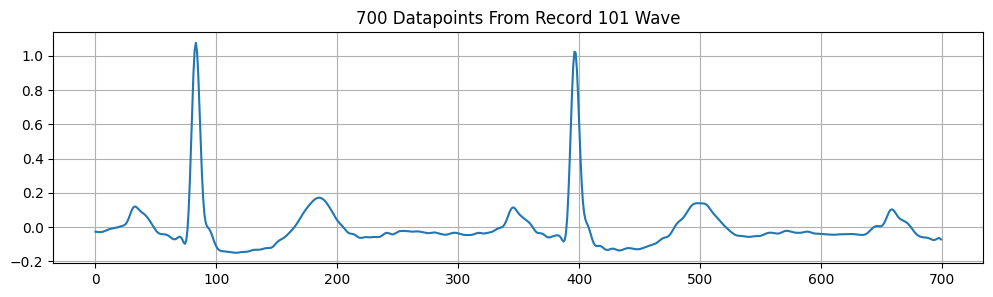

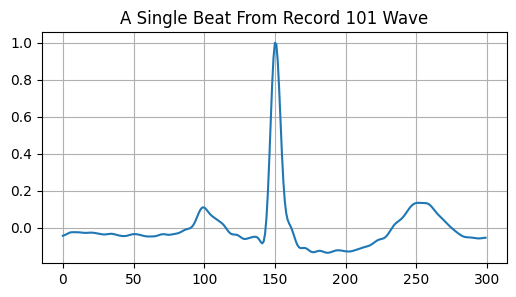


(100017, 300) (100017,)
Class distribution: [75016, 7129, 2546, 8071, 7255]


In [5]:
# Segment size
window_size = SEGMENT_SIZE

# Define arrhythmia classes
classes = ['N', 'V', 'A', 'L', 'R']  # Normal, Ventricular Premature (VP), Atrial Premature (AP), Left Bundle Branch Block (LBBB), Right Bundle Branch Block (RBBB)
n_classes = len(classes)
count_classes = [0] * n_classes

# Initialize lists to store beats and labels
X = list()
y = list()

# Fetch record files from the dataset directory
filenames = next(os.walk(path))[2]
filenames.sort()

# Process each record and annotation
for filename in filenames:
    example_beat_printed = False
    # Only process .dat files (the signal data files)
    if filename.endswith('.dat'):
        record_name = filename.split('.')[0]

        # Read the record (signals) and annotations
        if record_name == '114':  # MLII is channel 1 not 0
            record = wfdb.rdrecord((path + record_name), channels=[1])
        else:
            record = wfdb.rdrecord((path + record_name), channels=[0])

        annotation = wfdb.rdann(path + record_name, 'atr')

        signals_original = record.p_signal[:, 0]  # Taking MLII
        signals = denoise(signals_original)

        # Process the annotations to extract beats
        for i in range(len(annotation.sample)):
            arrhythmia_type = annotation.symbol[i]

            # Plot an example to the signals
            if i == 1 and record_name == '101':
                # Plot each patient's signal
                plt.figure(figsize=(12, 3))
                plt.title(f"700 Datapoints From Record {record_name} Wave")
                plt.plot(signals[0:700])
                plt.grid(True)
                plt.show()

            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                pos = annotation.sample[i]  # Position of the R-peak (sample index)

                # Ensure we don't go out of bounds when extracting the beat
                if window_size//2 <= pos < len(signals) - window_size//2:
                    beat = signals[pos-window_size//2:pos+window_size//2]
                    beat = stats.zscore(beat)  # Z-score normalization
                    beat = beat/ np.max(np.abs(beat)) # Unity scaling

                    # Plot an example beat (once)
                    if record_name == '101' and not example_beat_printed:
                        print() # Print an empty space before figure
                        plt.figure(figsize=(6, 3))
                        plt.title(f"A Single Beat From Record {record_name} Wave")
                        plt.plot(beat)
                        plt.grid(True)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)  # 300 point ECG vectors
                    y.append(arrhythmia_index)  # Arrhythmia class labels
                    count_classes[arrhythmia_index] += 1

print() # Print an empty space
print(np.shape(X), np.shape(y))
print("Class distribution:", count_classes)

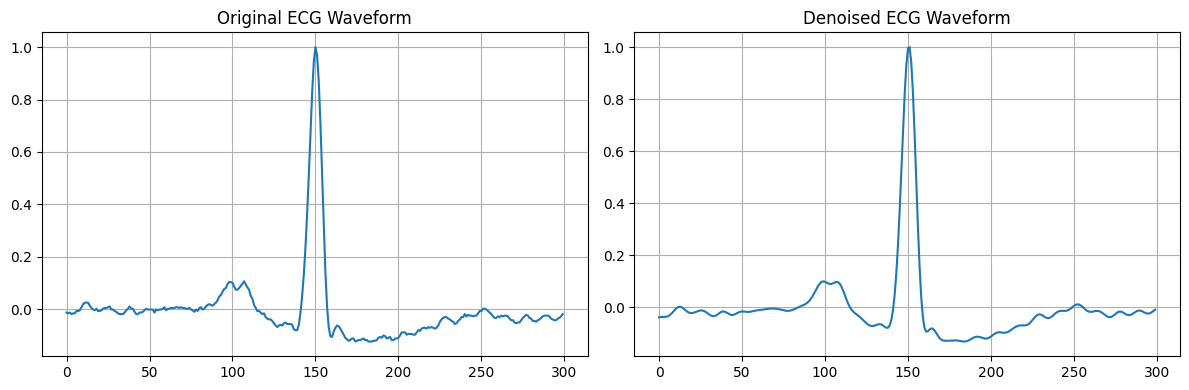

In [6]:
pos = annotation.sample[3]  # Position of the R-peak (sample index)

if window_size//2 <= pos < len(signals_original) - window_size//2:
  beat_original = signals_original[pos-window_size//2:pos+window_size//2]
  beat_original = stats.zscore(beat_original)  # Z-score normalization
  beat_original = beat_original/ np.max(np.abs(beat_original)) # Unity scaling

  beat = signals[pos-window_size//2:pos+window_size//2]
  beat = stats.zscore(beat)  # Z-score normalization
  beat = beat/ np.max(np.abs(beat)) # Unity scaling

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Create a figure with 1 row and 2 columns
# fig.suptitle("ECG Waveforms")  # Add a common title for both plots

# Plot the original ECG waveform
axs[0].set_title("Original ECG Waveform")
axs[0].plot(beat_original)
axs[0].grid(True)

# Plot the denoised ECG waveform
axs[1].set_title("Denoised ECG Waveform")
axs[1].plot(beat)
axs[1].grid(True)

# Display the plots
plt.tight_layout()  # Adjust layout to fit titles and labels
plt.show()

In [7]:
# Creating a data frame
X_df = pd.DataFrame(X)
X_df[len(X[0])] = y
X_df.shape

(100017, 301)

300
0    75016
3     8071
4     7255
1     7129
2     2546
Name: count, dtype: int64


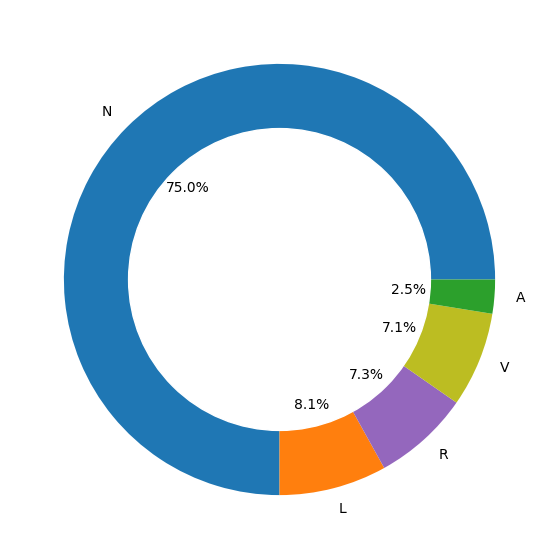

In [8]:
# Distribution of data
per_class = X_df[X_df.shape[1]-1].value_counts()
print(per_class)

plt.figure(figsize=(7,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [9]:
# Resampling the dataset to get to an even distribution
# TEST_SET_SIZE test data and TRAIN_SET_SIZE training data from each class
n_train = TRAIN_SET_SIZE
n_test = TEST_SET_SIZE
n_total = n_train + n_test

test_ratio = n_test/(n_total)

train = pd.DataFrame()
test = pd.DataFrame()

for class_value in range(5):

    # Filter the dataframe for the current class
    df_class = X_df[X_df[300] == class_value]

    # Randomly sample 2500 rows (or all rows if less )
    df_sampled_class = df_class.sample(n=min(n_total, len(df_class)), random_state=42)

    train_class, test_class = train_test_split(df_sampled_class, test_size= test_ratio)

    # Append the sampled rows to the new dataframe
    train = pd.concat([train, train_class])
    test = pd.concat([test, test_class])

# Reset index of the new dataframe
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Display the new dataframe
train.shape, test.shape

((10000, 301), (2500, 301))

In [10]:
per_class = train[train.shape[1]-1].value_counts()
print(per_class)

300
0    2000
1    2000
2    2000
3    2000
4    2000
Name: count, dtype: int64


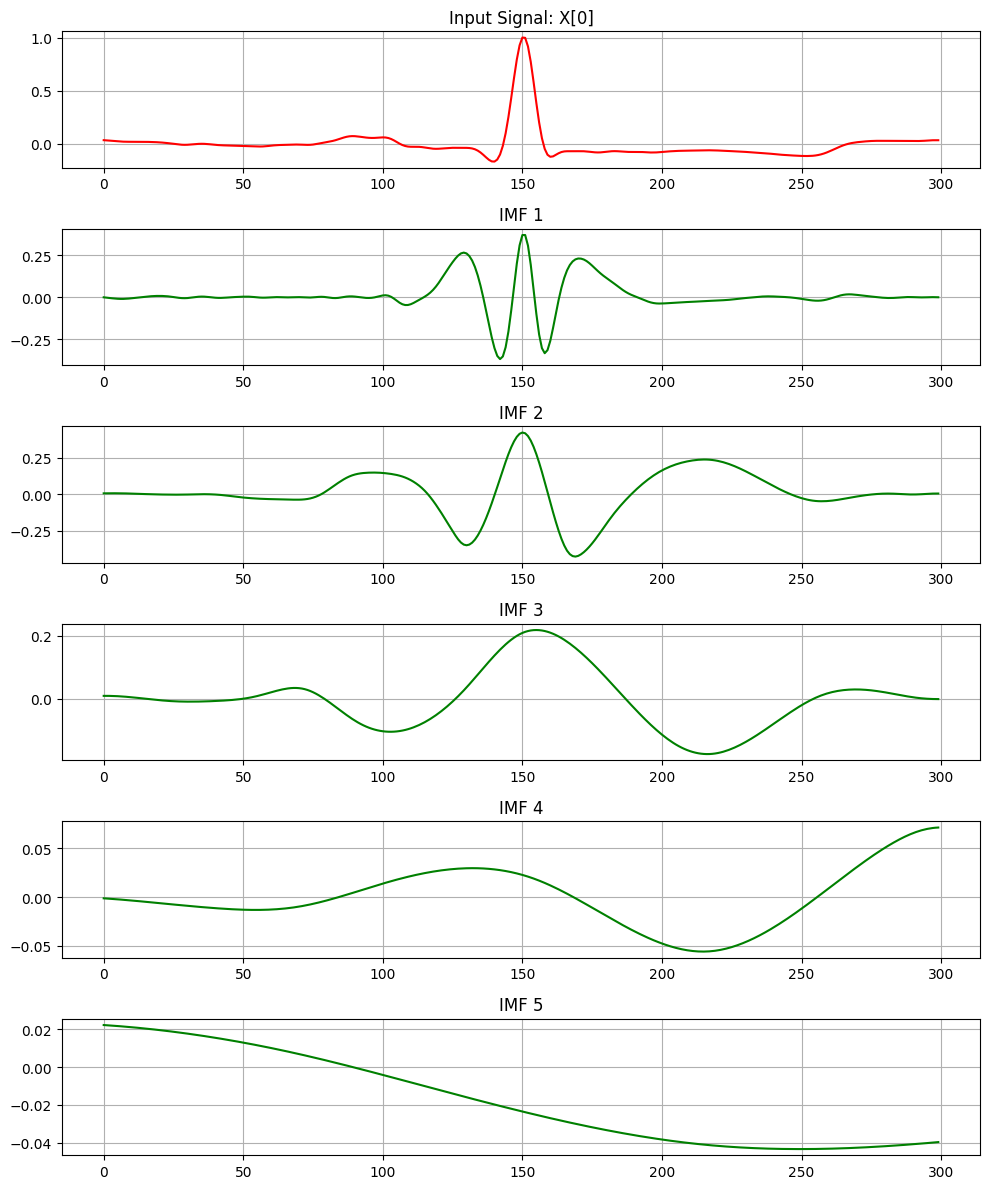

In [11]:
# Execute EEMD on signal
IMFs = emd(X[0], max_imf=EMD_IMFS)
N = IMFs.shape[0] # Number of subplots

plt.figure(figsize=(10, 2*(N+1)))  # Adjust the height based on the number of IMFs

# Plot the input signal
plt.subplot(N+1, 1, 1)
plt.plot(X[0], "r")
plt.title("Input Signal: X[0]")
plt.grid(True)

# Plot each IMF
for n, imf in enumerate(IMFs[:]):
    plt.subplot(N+1, 1, n + 2)
    plt.plot(imf, "g")
    plt.title(f"IMF {n + 1}")
    plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
train_features_df = get_features_df(train, "emd")
test_features_df = get_features_df(test, "emd")

Started extracting features
Decomposed segment 100; Extracted features from segment 100; Created a dataframe for segment 100.
Decomposed segment 200; Extracted features from segment 200; Created a dataframe for segment 200.
Decomposed segment 300; Extracted features from segment 300; Created a dataframe for segment 300.
Decomposed segment 400; Extracted features from segment 400; Created a dataframe for segment 400.
Decomposed segment 500; Extracted features from segment 500; Created a dataframe for segment 500.
Decomposed segment 600; Extracted features from segment 600; Created a dataframe for segment 600.
Decomposed segment 700; Extracted features from segment 700; Created a dataframe for segment 700.
Decomposed segment 800; Extracted features from segment 800; Created a dataframe for segment 800.
Decomposed segment 900; Extracted features from segment 900; Created a dataframe for segment 900.
Decomposed segment 1000; Extracted features from segment 1000; Created a dataframe for seg

In [13]:
print(train_features_df.shape)
print(test_features_df.shape)

(10000, 21)
(2500, 21)


In [14]:
train_features_df.head()

,SV 1,CV 1,SEN 1,BP 1,SV 2,CV 2,SEN 2,BP 2,SV 3,CV 3,...,BP 3,SV 4,CV 4,SEN 4,BP 4,Class,SV 5,CV 5,SEN 5,BP 5
0,0.026197,116.466457,2.182015,0.015871,0.108689,48.836661,2.307256,0.017745,0.104095,8.798875,...,0.039046,0.020889,9.270434,1.811341,0.010937,0.0,NaN,NaN,NaN,NaN
1,0.076503,53.937939,2.343828,0.018312,0.096463,323.327478,2.943647,0.028884,0.085911,43.315298,...,0.017543,0.040114,3.149753,1.013212,0.003422,0.0,NaN,NaN,NaN,NaN
2,0.128973,217.788850,2.271217,0.017195,0.202645,42.642255,2.548382,0.021648,0.099632,13.227875,...,0.009657,0.022423,1.574646,1.589406,0.008421,0.0,NaN,NaN,NaN,NaN
3,0.123998,689.066192,1.498401,0.007484,0.071869,316.435096,2.142003,0.015294,0.268386,153.292431,...,0.001476,0.029812,50.805599,1.661473,0.009202,0.0,NaN,NaN,NaN,NaN
4,0.015043,32.900493,1.751111,0.010221,0.154048,4431.948988,2.335862,0.018187,0.184293,149.489695,...,0.014480,0.094223,4033.246656,0.453965,0.000687,0.0,0.038157,1.451677,0.271017,0.000245


In [15]:
test_features_df.head()

,SV 1,CV 1,SEN 1,BP 1,SV 2,CV 2,SEN 2,BP 2,SV 3,CV 3,...,BP 3,SV 4,CV 4,SEN 4,BP 4,SV 5,CV 5,SEN 5,BP 5,Class
0,0.045516,468.203440,2.809503,0.026311,0.145108,278.765224,2.298868,0.017616,0.146803,30.883624,...,0.018109,0.051117,21.436767,1.553556,0.008045,0.002077,27.453285,0.411067,0.000563,0.0
1,0.047122,145.068580,1.206995,0.004856,0.107354,92.818435,2.954600,0.029099,0.150061,214.955010,...,0.033406,0.045926,24.376252,1.733897,0.010021,0.002255,0.080753,0.347168,0.000402,0.0
2,0.012500,43.842956,1.694701,0.009573,0.202771,7.913674,3.368888,0.037831,0.085250,6.854570,...,0.042263,0.100174,23.721466,0.126945,0.000054,0.010274,6.962330,0.241021,0.000194,0.0
3,0.084450,138.323431,2.616230,0.022816,0.166192,42.360226,3.559156,0.042225,0.073187,11.411087,...,0.040005,0.029223,4.251726,1.522819,0.007730,NaN,NaN,NaN,NaN,0.0
4,0.014804,23865.681609,1.626880,0.008822,0.137959,237.068805,2.467178,0.020290,0.228466,311.117107,...,0.001874,0.049050,8.665392,1.372230,0.006277,0.007431,0.008933,0.636017,0.001348,0.0


In [16]:
# Remove rows where any cell has a NaN value
adjusted_train_df = train_features_df.dropna()
adjusted_test_df = test_features_df.dropna()

In [17]:
print(adjusted_train_df.shape)

(3263, 21)


In [18]:
print(adjusted_test_df.shape)

(831, 21)


In [19]:
per_class_train = adjusted_train_df["Class"].value_counts()
print(per_class_train)

Class
2.0    1216
0.0     907
4.0     688
3.0     245
1.0     207
Name: count, dtype: int64


In [20]:
per_class_test = adjusted_test_df["Class"].value_counts()
print(per_class_test)

Class
2.0    294
0.0    231
4.0    172
3.0     77
1.0     57
Name: count, dtype: int64


In [21]:
# Set the display options
pd.set_option('display.max_rows', None)  # This line will allow all rows to be displayed.
pd.set_option('display.max_columns', None)  # This line will allow all columns to be displayed.
pd.set_option('display.width', None)  # This ensures that the display width is adjusted to show each line completely.

# Create an empty DataFrame with specified columns
columns = ['Features', 'Normal', 'PVC', 'APC', 'LBBB', 'RBBB']  # Example column names
feature_stats = pd.DataFrame(index=range(EMD_IMFS*4), columns=columns)

for class_label in range(5):  # Looping through classes 0 to 4
    # Filter the dataframe for the current class
    class_df = adjusted_train_df[adjusted_train_df['Class'] == class_label]
    i = 0
    for column in class_df.columns[:-1]:

        # Calculate the median
        median = class_df[column].median()

        # Calculate Q1 and Q3
        Q1 = class_df[column].quantile(0.25)
        Q3 = class_df[column].quantile(0.75)

        # Calculate IQR
        IQR = Q3 - Q1

        feature_stats.iat[i, 0] = column
        feature_stats.iat[i, class_label+1] = f"{median:.5f} ± {IQR/2:.5f}"
        i = i + 1

feature_stats

,Features,Normal,PVC,APC,LBBB,RBBB
0,SV 1,0.04331 ± 0.02454,0.09854 ± 0.06225,0.11804 ± 0.05691,0.06259 ± 0.02039,0.06000 ± 0.04253
1,CV 1,191.55936 ± 405.71184,249.62779 ± 449.14311,214.96905 ± 399.41384,114.74085 ± 261.84915,211.97773 ± 384.89754
2,SEN 1,2.00857 ± 0.39217,1.93433 ± 0.62834,2.12459 ± 0.24339,1.83720 ± 0.47045,2.25440 ± 0.54514
3,BP 1,0.01345 ± 0.00529,0.01247 ± 0.00809,0.01505 ± 0.00349,0.01125 ± 0.00610,0.01694 ± 0.00824
4,SV 2,0.12742 ± 0.03599,0.16528 ± 0.06747,0.20689 ± 0.04149,0.12033 ± 0.02738,0.11843 ± 0.03158
5,CV 2,184.24974 ± 363.46656,223.59838 ± 695.44287,385.16077 ± 776.96526,106.32016 ± 197.39719,226.98576 ± 538.19517
6,SEN 2,2.41413 ± 0.32864,2.52670 ± 0.70271,2.58653 ± 0.37490,2.81805 ± 1.10915,3.00320 ± 0.69181
7,BP 2,0.01943 ± 0.00533,0.02128 ± 0.01254,0.02230 ± 0.00656,0.02647 ± 0.02305,0.03006 ± 0.01369
8,SV 3,0.15065 ± 0.03017,0.13124 ± 0.02812,0.15215 ± 0.03417,0.09961 ± 0.04150,0.14101 ± 0.03738
9,CV 3,70.31928 ± 146.33985,39.96405 ± 85.07411,34.18928 ± 132.81127,30.93416 ± 76.60279,54.39070 ± 86.47515


In [22]:
adjusted_train_df.to_csv('/content/drive/MyDrive/BSP Paper Implementation/CSVs/Final Report/5EMD(~NaN)_train.csv', index=False)
adjusted_test_df.to_csv('/content/drive/MyDrive/BSP Paper Implementation/CSVs/Final Report/5EMD(~NaN)_test.csv', index=False)